In [1]:
import os
import re
import time
import copy

from pathlib import Path
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import torchvision
from torchvision import models, datasets, transforms

# import online augmentation libraries
from augmentation_libraries.online_augmentation import augment_image_without_seed

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print(torch.cuda.is_available())

PyTorch Version:  2.1.0+cu118
Torchvision Version:  0.16.0+cu118
True


input dir

In [2]:
CURRENT_DIR = os.getcwd()
MAIN_FOLDER = Path(CURRENT_DIR).parent
OUTPUT_FOLDER = os.path.join(MAIN_FOLDER, 'aligned')  
FOLD_DATA = os.path.join(MAIN_FOLDER, 'fold_data') 

BATCH_SIZE = 32

cuda_avail = torch.cuda.is_available()
DEVICE = torch.device("cuda" if cuda_avail else "cpu")

print(
    f"Current Directory: {CURRENT_DIR}\n",
    f"Main Folder: {MAIN_FOLDER}\n",
    f"Output Folder: {OUTPUT_FOLDER}\n",
    f"Fold Data Folder: {FOLD_DATA}\n",
)

Current Directory: /home/user/CZ4042-SC4001-NND/architecture
 Main Folder: /home/user/CZ4042-SC4001-NND
 Output Folder: /home/user/CZ4042-SC4001-NND/aligned
 Fold Data Folder: /home/user/CZ4042-SC4001-NND/fold_data



Data processing

In [3]:
# Data Transforms
def get_data_transforms():
    normalize = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
    common_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(*normalize)
    ])
    return {
        'train': common_transform,
        'val': common_transform,
        'test': common_transform
    }

data_transforms = get_data_transforms()

In [4]:
class BasicImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, augment=False, num_augmentations=2):
        """
        Args:
            image_paths (list): List of image file paths.
            labels (list): List of corresponding labels.
            transform (callable, optional): Transformations to apply to the images.
            augment (bool): Whether to apply online augmentation.
            num_augmentations (int): Number of augmented versions to create per image.
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.augment = augment
        self.num_augmentations = num_augmentations
        
    def __len__(self):
        # Return the actual number of samples after augmentation
        if self.augment:
            return len(self.image_paths) * (self.num_augmentations)
        return len(self.image_paths)
        
    def get_original_len(self):
        """Return the number of original images (without augmentation)"""
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        # Calculate which original image to use
        if self.augment:
            original_idx = idx // self.num_augmentations
        else:
            original_idx = idx
            
        image = Image.open(self.image_paths[original_idx]).convert('RGB')
        label = torch.tensor(self.labels[original_idx], dtype=torch.long)

        if self.augment:
            # When augmenting, first apply augmentation (which already returns a tensor)
            augmented_tensor = augment_image_without_seed(image, final_resolution=(224, 224))
            
            # Skip ToTensor and only apply normalization if needed
            if self.transform:
                # Extract the normalization from transform and apply it directly
                for t in self.transform.transforms:
                    if isinstance(t, transforms.Normalize):
                        augmented_tensor = t(augmented_tensor)
                        
            return augmented_tensor, label

        # For non-augmented images, apply the full transform
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        return image, label

In [5]:
def load_folds_dataset(image_root, fold_dir, fold_files):
    image_paths = []
    labels = []

    for fold_file in fold_files:
        print(f"Reading fold file: {fold_file}")
        with open(os.path.join(fold_dir, fold_file), 'r') as f:
            next(f)  
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) < 5:
                    continue
                user_id = parts[0]
                original_img_name = parts[1]
                gender = parts[4].lower()

                if gender not in ["m", "f"]:
                    continue
                label = 0 if gender == "m" else 1

                user_folder = os.path.join(image_root, user_id)
                if not os.path.isdir(user_folder):
                    continue

                for file in os.listdir(user_folder):
                    if original_img_name in file:
                        full_path = os.path.join(user_folder, file)
                        if os.path.isfile(full_path):
                            image_paths.append(full_path)
                            labels.append(label)
                        break

    return image_paths, labels


In [6]:
def get_dataloaders(batch_size, train_folds, val_fold):
    train_image_paths, train_labels = load_folds_dataset(OUTPUT_FOLDER, FOLD_DATA, train_folds)
    val_image_paths, val_labels = load_folds_dataset(OUTPUT_FOLDER, FOLD_DATA, [val_fold])

    train_dataset = BasicImageDataset(train_image_paths, train_labels, transform=data_transforms['train'], augment=True)
    val_dataset = BasicImageDataset(val_image_paths, val_labels, transform=data_transforms['val'], augment=False)

    print(f"Train size: {len(train_dataset)} (from {train_dataset.get_original_len()} original images)")
    print(f"Val size: {len(val_dataset)}")

    if train_dataset.get_original_len() == 0 or len(val_dataset) == 0:
        return None

    num_workers = 8 if cuda_avail else 0
    pin_memory = True if cuda_avail else False
    # Create DataLoader for training and validation datasets
    # Use num_workers and pin_memory only if CUDA is available
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

    return {'train': train_loader, 'val': val_loader}

model

In [7]:
# class ResnetGender(nn.Module):
#     def __init__(self, layers=18, pretrained=True, drop_rate=0.3):
#         super().__init__()
        
#         if layers == 18:
#             base_model = torchvision.models.resnet18(pretrained=pretrained)
#             block_expansion = 1

#         self.resnet = nn.Sequential(*list(base_model.children())[:-1]) 
#         self.pool = nn.AdaptiveAvgPool2d((1, 1))  
        
#         self.extra_layer = nn.Sequential(
#             nn.Linear(block_expansion * 512, 256),
#             nn.BatchNorm1d(256),
#             nn.Dropout(drop_rate),
#             nn.ReLU(),
#         )
#         self.gender_predictor = nn.Sequential(
#             nn.Linear(256, 128),
#             nn.BatchNorm1d(128),
#             nn.Dropout(drop_rate),
#             nn.ReLU(),
#             nn.Linear(128, 2)
#         )

#     def forward(self, x):
#         x = self.resnet(x)
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = self.extra_layer(x)
#         return self.gender_predictor(x)


In [8]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, eps=0.1, reduction='mean'):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.eps = eps
        self.reduction = reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum':
            loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':
                loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, reduction=self.reduction)

Train

In [9]:
def load_model(drop_rate=0.3):
    base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    num_ftrs = base_model.fc.in_features
    base_model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 128),
        nn.BatchNorm1d(128),
        nn.Dropout(drop_rate),
        nn.ReLU(),
        nn.Linear(128, 2)  
    )
    return base_model.to(DEVICE)

In [10]:
def train_model(model, dataloaders, optimizer, num_epochs=50, patience=10):
    criterion = LabelSmoothingCrossEntropy()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.25)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")
    epochs_no_improve = 0
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_prec': [], 'val_prec': [],
        'train_rec': [], 'val_rec': [],
        'train_f1': [], 'val_f1': [],
    }
    
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0
            all_preds, all_labels = [], []

            for inputs, labels in dataloaders[phase]:
                # Start the minibatch timer
                minibatch_start_time = time.time()
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = torch.argmax(outputs, dim=1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                # End the minibatch timer
                minibatch_time = time.time() - minibatch_start_time

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = accuracy_score(all_labels, all_preds)
            epoch_prec = precision_score(all_labels, all_preds, zero_division=0)
            epoch_rec = recall_score(all_labels, all_preds, zero_division=0)
            epoch_f1 = f1_score(all_labels, all_preds, zero_division=0)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            history[f'{phase}_prec'].append(epoch_prec)
            history[f'{phase}_rec'].append(epoch_rec)
            history[f'{phase}_f1'].append(epoch_f1)

            print(f"{phase.upper()} — Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} | "
                  f"Prec: {epoch_prec:.4f} | Rec: {epoch_rec:.4f} | F1: {epoch_f1:.4f}")

            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
        if phase == 'train':
            scheduler.step()
            
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break
        
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch + 1} completed in {epoch_time:.2f} seconds.")

    def plot_training_curves(history):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['val_acc'], label='Validation Accuracy')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Validation Accuracy over Epochs")
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(history['val_loss'], label='Validation Loss', color='orange')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Validation Loss over Epochs")
        plt.legend()
        plt.tight_layout()
        plt.show()

    plot_training_curves(history)
    model.load_state_dict(best_model_wts)
    print(f"\nTraining complete — Best Val Loss: {best_loss:.4f}")
    return model, history


Fold 0: Val = fold_0_data.txt, Train = ['fold_1_data.txt', 'fold_2_data.txt', 'fold_3_data.txt', 'fold_4_data.txt']
Reading fold file: fold_1_data.txt
Reading fold file: fold_2_data.txt
Reading fold file: fold_3_data.txt
Reading fold file: fold_4_data.txt
Reading fold file: fold_0_data.txt
Train size: 26994 (from 13497 original images)
Val size: 3995

Epoch 1/50
TRAIN — Loss: 0.6579 | Acc: 0.6302 | Prec: 0.6507 | Rec: 0.7074 | F1: 0.6779
VAL — Loss: 0.6241 | Acc: 0.6538 | Prec: 0.7132 | Rec: 0.4851 | F1: 0.5775
Epoch 1 completed in 39.14 seconds.

Epoch 2/50
TRAIN — Loss: 0.6013 | Acc: 0.7106 | Prec: 0.7219 | Rec: 0.7707 | F1: 0.7455
VAL — Loss: 0.5852 | Acc: 0.7242 | Prec: 0.7515 | Rec: 0.6489 | F1: 0.6964
Epoch 2 completed in 77.21 seconds.

Epoch 3/50
TRAIN — Loss: 0.5675 | Acc: 0.7480 | Prec: 0.7577 | Rec: 0.7966 | F1: 0.7767
VAL — Loss: 0.5737 | Acc: 0.7474 | Prec: 0.7441 | Rec: 0.7346 | F1: 0.7393
Epoch 3 completed in 116.32 seconds.

Epoch 4/50
TRAIN — Loss: 0.5489 | Acc: 0.7683

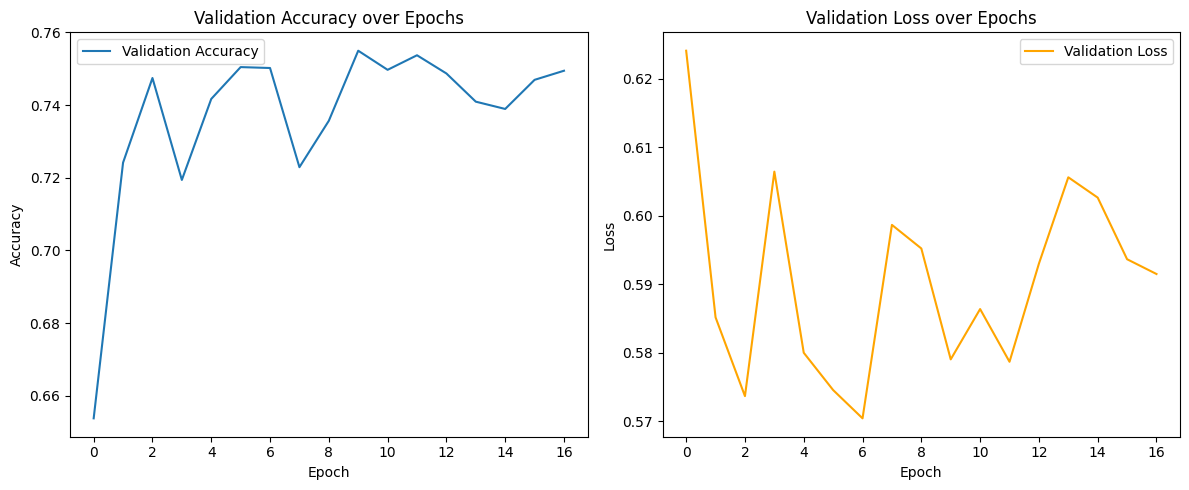


Training complete — Best Val Loss: 0.5705
Fold 1: Val = fold_1_data.txt, Train = ['fold_0_data.txt', 'fold_2_data.txt', 'fold_3_data.txt', 'fold_4_data.txt']
Reading fold file: fold_0_data.txt
Reading fold file: fold_2_data.txt
Reading fold file: fold_3_data.txt
Reading fold file: fold_4_data.txt
Reading fold file: fold_1_data.txt
Train size: 27766 (from 13883 original images)
Val size: 3609

Epoch 1/50
TRAIN — Loss: 0.6188 | Acc: 0.6844 | Prec: 0.6934 | Rec: 0.7274 | F1: 0.7100
VAL — Loss: 0.6030 | Acc: 0.7096 | Prec: 0.7568 | Rec: 0.7007 | F1: 0.7277
Epoch 1 completed in 38.24 seconds.

Epoch 2/50
TRAIN — Loss: 0.5676 | Acc: 0.7510 | Prec: 0.7596 | Rec: 0.7770 | F1: 0.7682
VAL — Loss: 0.6013 | Acc: 0.7132 | Prec: 0.6850 | Rec: 0.8924 | F1: 0.7750
Epoch 2 completed in 76.14 seconds.

Epoch 3/50
TRAIN — Loss: 0.5483 | Acc: 0.7675 | Prec: 0.7723 | Rec: 0.7974 | F1: 0.7847
VAL — Loss: 0.5942 | Acc: 0.7140 | Prec: 0.6869 | Rec: 0.8884 | F1: 0.7748
Epoch 3 completed in 115.70 seconds.

Ep

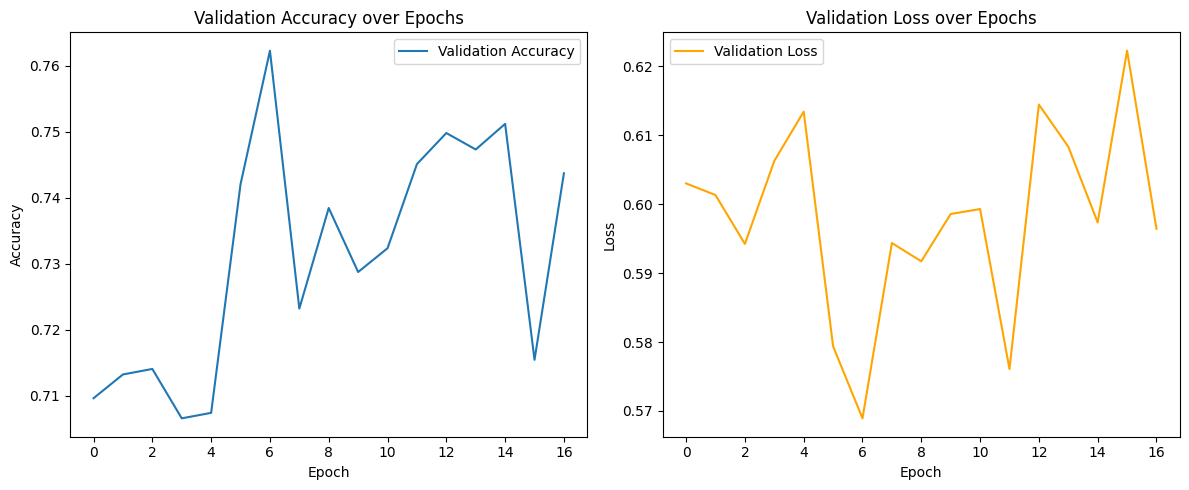


Training complete — Best Val Loss: 0.5689
Fold 2: Val = fold_2_data.txt, Train = ['fold_0_data.txt', 'fold_1_data.txt', 'fold_3_data.txt', 'fold_4_data.txt']
Reading fold file: fold_0_data.txt
Reading fold file: fold_1_data.txt
Reading fold file: fold_3_data.txt
Reading fold file: fold_4_data.txt
Reading fold file: fold_2_data.txt
Train size: 28710 (from 14355 original images)
Val size: 3137

Epoch 1/50
TRAIN — Loss: 0.6414 | Acc: 0.6560 | Prec: 0.6667 | Rec: 0.7001 | F1: 0.6830
VAL — Loss: 0.5822 | Acc: 0.7268 | Prec: 0.7477 | Rec: 0.7802 | F1: 0.7636
Epoch 1 completed in 40.95 seconds.

Epoch 2/50
TRAIN — Loss: 0.5854 | Acc: 0.7311 | Prec: 0.7401 | Rec: 0.7583 | F1: 0.7491
VAL — Loss: 0.6231 | Acc: 0.6927 | Prec: 0.8240 | Rec: 0.5806 | F1: 0.6812
Epoch 2 completed in 81.42 seconds.

Epoch 3/50
TRAIN — Loss: 0.5683 | Acc: 0.7507 | Prec: 0.7573 | Rec: 0.7786 | F1: 0.7678
VAL — Loss: 0.6045 | Acc: 0.7000 | Prec: 0.7878 | Rec: 0.6426 | F1: 0.7079
Epoch 3 completed in 121.56 seconds.

Ep

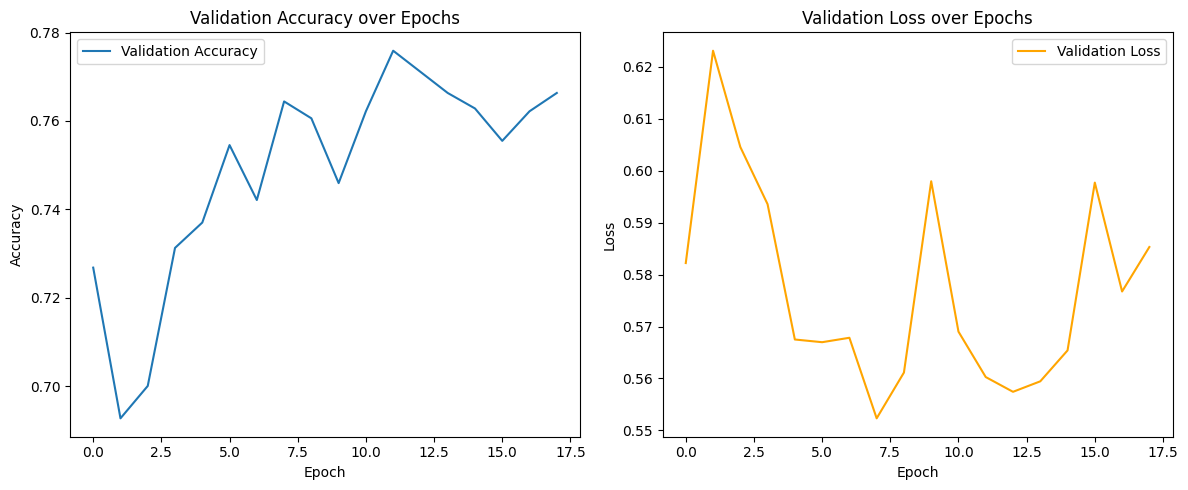


Training complete — Best Val Loss: 0.5523
Fold 3: Val = fold_3_data.txt, Train = ['fold_0_data.txt', 'fold_1_data.txt', 'fold_2_data.txt', 'fold_4_data.txt']
Reading fold file: fold_0_data.txt
Reading fold file: fold_1_data.txt
Reading fold file: fold_2_data.txt
Reading fold file: fold_4_data.txt
Reading fold file: fold_3_data.txt
Train size: 28372 (from 14186 original images)
Val size: 3306

Epoch 1/50
TRAIN — Loss: 0.6180 | Acc: 0.6893 | Prec: 0.6997 | Rec: 0.7316 | F1: 0.7153
VAL — Loss: 0.5848 | Acc: 0.7459 | Prec: 0.7591 | Rec: 0.7827 | F1: 0.7707
Epoch 1 completed in 38.64 seconds.

Epoch 2/50
TRAIN — Loss: 0.5676 | Acc: 0.7514 | Prec: 0.7610 | Rec: 0.7785 | F1: 0.7697
VAL — Loss: 0.5630 | Acc: 0.7632 | Prec: 0.7441 | Rec: 0.8625 | F1: 0.7990
Epoch 2 completed in 78.97 seconds.

Epoch 3/50
TRAIN — Loss: 0.5493 | Acc: 0.7694 | Prec: 0.7775 | Rec: 0.7954 | F1: 0.7863
VAL — Loss: 0.5509 | Acc: 0.7753 | Prec: 0.7857 | Rec: 0.8088 | F1: 0.7970
Epoch 3 completed in 118.02 seconds.

Ep

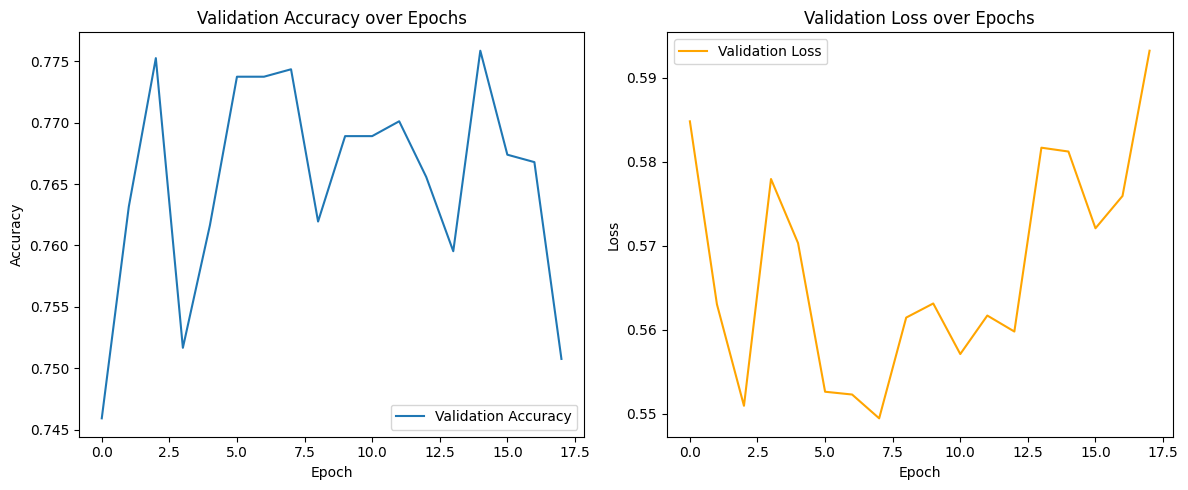


Training complete — Best Val Loss: 0.5494
Fold 4: Val = fold_4_data.txt, Train = ['fold_0_data.txt', 'fold_1_data.txt', 'fold_2_data.txt', 'fold_3_data.txt']
Reading fold file: fold_0_data.txt
Reading fold file: fold_1_data.txt
Reading fold file: fold_2_data.txt
Reading fold file: fold_3_data.txt
Reading fold file: fold_4_data.txt
Train size: 28094 (from 14047 original images)
Val size: 3445

Epoch 1/50
TRAIN — Loss: 0.6218 | Acc: 0.6831 | Prec: 0.6912 | Rec: 0.7381 | F1: 0.7139
VAL — Loss: 0.6357 | Acc: 0.6656 | Prec: 0.7186 | Rec: 0.6190 | F1: 0.6651
Epoch 1 completed in 42.02 seconds.

Epoch 2/50
TRAIN — Loss: 0.5589 | Acc: 0.7609 | Prec: 0.7651 | Rec: 0.7989 | F1: 0.7816
VAL — Loss: 0.6587 | Acc: 0.6668 | Prec: 0.7185 | Rec: 0.6228 | F1: 0.6672
Epoch 2 completed in 84.20 seconds.

Epoch 3/50
TRAIN — Loss: 0.5375 | Acc: 0.7798 | Prec: 0.7839 | Rec: 0.8131 | F1: 0.7983
VAL — Loss: 0.6195 | Acc: 0.6987 | Prec: 0.7573 | Rec: 0.6450 | F1: 0.6967
Epoch 3 completed in 127.05 seconds.

Ep

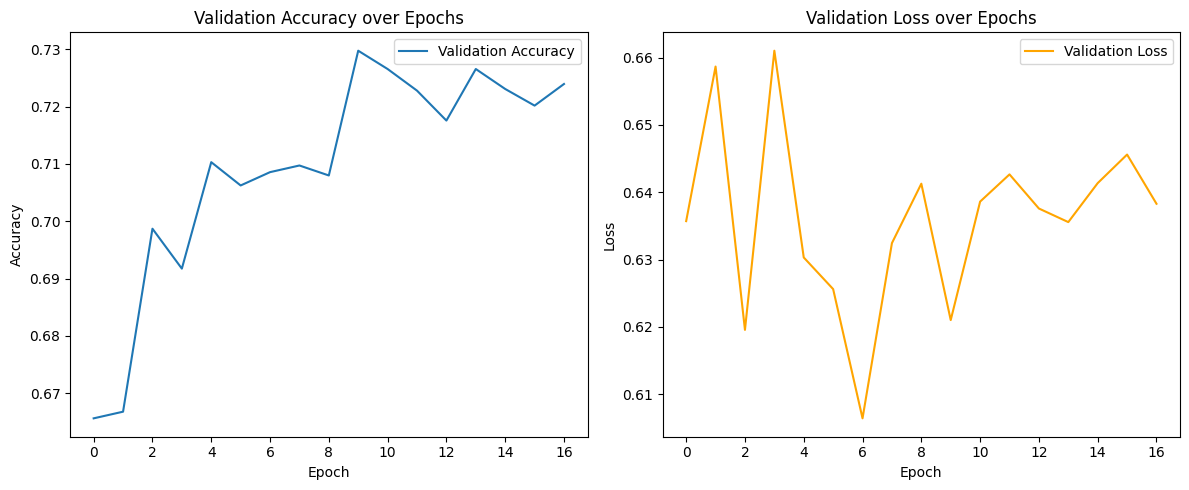


Training complete — Best Val Loss: 0.6064


In [11]:
all_folds = [f"fold_{i}_data.txt" for i in range(5)]
for fold_idx in range(5):
    val_fold = all_folds[fold_idx]
    train_folds = [f for i, f in enumerate(all_folds) if i != fold_idx]
    print(f"Fold {fold_idx}: Val = {val_fold}, Train = {train_folds}")

    dataloaders = get_dataloaders(batch_size=32, train_folds=train_folds, val_fold=val_fold)

    model = load_model(drop_rate=0.3)
    params_to_update = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(params_to_update, lr=0.001)

    model, history = train_model(model, dataloaders, optimizer, num_epochs=50)
    best_val_acc = max(history['val_acc'])

In [12]:
# Save the model
torch.save(model, 'resnet_test.pth')
print("Model saved as efficientnet_test.pth")

Model saved as efficientnet_test.pth
